In [1]:
import cPickle as pickle
import numpy as np
import nltk 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
from datetime import date

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

with open('word_embeddings/run_info.p', 'r') as f:
    x = pickle.load(f)

info2index = x['info2index']


In [2]:
event_embeddings = pd.read_csv("word_embeddings/u_epoch_500.csv", header = None)
embedding_lst = []
for row in event_embeddings.iterrows():
    index, data = row 
    temp = data.tolist()
    actual_data = [float(x) for x in temp[0].split()]
    embedding_lst.append(actual_data)

In [3]:
number_to_month = {"01": "Jan", "02":"Feb", "03":"Mar", "04":"Apr", "05":"May", "06": "Jun", "07":"Jul", "08":"Aug", "09":"Sep", "10":"Oct", "11":"Nov", "12":"Dec"}
def conv_num_to_string(d): #ex: conv_num_to_string('20041001') = '01-Oct-04'
    year = d[0:4]
    month = d[4:6]
    day = d[6:8]
    new = day + "-" + number_to_month[month] + "-" + year[2:4]
    return new 

def numeric_day_distance(day1, day2): #'20140111', '20150115'
    d0 = date(int(day1[0:4]), int(day1[4:6]), int(day1[6:8]) )
    d1 = date(int(day2[0:4]), int(day2[4:6]), int(day2[6:8]) )
    delta = d0 - d1 
    return abs(delta.days)

In [4]:

stock_to_events = {}
for key_ in info2index:
    stock_ = key_[0]
    embedding_to_index = info2index[key_]
    date_ = key_[1]
    event = key_[2]
    new_value = [date_, embedding_to_index]
    if stock_ in stock_to_events: 
        stock_to_events[stock_].append(new_value)
    else:
        stock_to_events[stock_] = [new_value]

for stock_ in stock_to_events:
    stock_to_events[stock_] = sorted( stock_to_events[stock_], key = lambda x: x[0]  )

In [4]:
stock_to_events.keys()

['GOOGL', 'INTC', 'AAPL', 'CSCO', 'AMD', 'QCOM', 'NVDA', 'AMZN', 'MSFT', 'IBM']

In [5]:
stk_lst = []

for stock in stock_to_events:
    stock_length = {}
    stock_length["Number of Articles"] = len(stock_to_events[stock])
    stock_length["Stock Name"] = stock
    stk_lst.append(stock_length)

In [11]:
df[ ["Stock Name", "Number of Articles"]]

,Stock Name,Number of Articles
0,GOOGL,528
1,INTC,409
2,AAPL,2292
3,CSCO,229
4,AMD,23
5,QCOM,351
6,NVDA,54
7,AMZN,1062
8,MSFT,830
9,IBM,415


In [5]:
news_csv = pd.read_csv("news_data/news_reuters_10.csv", error_bad_lines=False, header = None, names = ["stock", "company", "date", "title", "summary", "type", "website"])

In [6]:
def up_down_ratio(stock, day_lag): #ex: sentiment_to_price_plot("AAPL", 1, 'neg')
    stock_data = news_csv[news_csv["stock"] == stock]
    stock_price_csv = pd.read_csv("price_data/"+ stock+"_2006-01-01_to_2017-11-01.csv")
    total = []
    for index, row in stock_data.iterrows():
    

        day = conv_num_to_string(str(row["date"]) )

        if day in stock_price_csv["Date"].values:

            

            row_index = stock_price_csv.index[stock_price_csv["Date"] == day].tolist()[0]
            next_price = stock_price_csv.iloc[row_index - day_lag  ]
            #print next_price["Date"], google_price_csv.iloc[row_index]["Date"]
            diff = next_price["Close"] - next_price["Open"]
            if diff >= 0.0:
                total.append(1) 
            else:
                total.append(0)
    return 100*sum(total)/len(total)
   

In [12]:
stk_lst = []

for stock in stock_to_events:
    if stock != 'IBM':
        stock_length = {}
        stock_length["Price Up Percentage"] = up_down_ratio(stock, 1)
        stock_length["Stock Name"] = stock
        stk_lst.append(stock_length)

In [28]:
df = pd.DataFrame(stk_lst)
df[["Stock Name", "Price Up Percentage"]]

,Stock Name,Price Up Percentage
0,GOOGL,49
1,INTC,49
2,AAPL,48
3,CSCO,60
4,AMD,50
5,QCOM,45
6,NVDA,72
7,AMZN,48
8,MSFT,51


In [7]:
news_csv = pd.read_csv("news_data/news_reuters_10.csv", error_bad_lines=False, header = None, names = ["stock", "company", "date", "title", "summary", "type", "website"])
google_price_csv = pd.read_csv("price_data/GOOGL_2006-01-01_to_2017-11-01.csv")

In [8]:


def short_term_embedding_to_class(stock, day_lag, training_ratio, shuff_bool, epoch_size):
    stock_price_csv = pd.read_csv("price_data/"+ stock+"_2006-01-01_to_2017-11-01.csv")
    
    
    
    temp_x = []
    temp_y = []
    for event in stock_to_events[stock]:
        
        
        day = conv_num_to_string( event[0]    )

        if day in stock_price_csv["Date"].values:

            temp_x.append( embedding_lst[event[1]]  )
            
            row_index = stock_price_csv.index[stock_price_csv["Date"] == day].tolist()[0]
            next_price_data = stock_price_csv.iloc[row_index - day_lag  ]
            
            next_price = next_price_data["Close"] - next_price_data["Open"]
            
            if next_price >= 0.0:
                pos_neg_class = 1
            else:
                pos_neg_class = 0
            temp_y.append(pos_neg_class)
    
    
    #--------------------------------------
    
    input_size = 100
    hidden_size = 150
    learning_rate = 0.001
    num_epochs = epoch_size
    batch_size = 100
    
    #--------------------------
    sample_size = len(temp_x)
    cut = int(training_ratio*float(sample_size) ) 
    train_x = temp_x[0:cut ]
    test_x = temp_x[cut+1:]
    
    train_y = temp_y[0:cut]
    test_y = temp_y[cut+1:]
    
    train_x = torch.FloatTensor(train_x)
    train_y = torch.LongTensor(train_y)
    
    
    test_x = torch.FloatTensor(test_x)
    test_y = torch.LongTensor(test_y)
    
    #-------------------------------------
    
    
    train = torch.utils.data.TensorDataset(train_x, train_y)
    train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size = batch_size, 
                                           shuffle=shuff_bool)
    
    
    test = torch.utils.data.TensorDataset(test_x, test_y)
    test_loader = torch.utils.data.DataLoader(dataset=test, 
                                           batch_size = batch_size, 
                                           shuffle=False)
    
    #------------------------------------------
    class Net(nn.Module):

        def __init__(self, input_size, hidden_size):
            super(Net, self).__init__()

            self.f1 = nn.Linear(input_size, hidden_size)
            self.sigmoid = nn.Sigmoid()
            self.f2 = nn.Linear(hidden_size, 2)
            self.softmax = nn.Softmax()
            
        def forward(self, x):
            out = self.f1(x)
            out = self.sigmoid(out)
            out = self.f2(out)
            out = self.sigmoid(out) 
            out = self.softmax(out) 
            return out 

    net = Net(input_size, hidden_size)

    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        for i, (inp, outp) in enumerate(train_loader):
            
            inp = Variable(inp)
            outp = Variable(outp)
            
            optimizer.zero_grad()
            outputs = net(inp)
            
            loss = criterion(outputs, outp.squeeze()  )
            loss.backward()
            optimizer.step()
            
    
    
    correct = 0
    total = 0
    for inp, lab in train_loader:
        inp = Variable(inp)
        
        outputs = net(inp)
        _, predicted = torch.max(outputs.data, 1)
        total += lab.size(0)
        correct += (predicted == lab).sum()


    train_accuracy = float(correct)/total 
    
    
    
            
    
    correct = 0
    total = 0
    for inp, lab in test_loader:
        inp = Variable(inp)
        
        outputs = net(inp)
        _, predicted = torch.max(outputs.data, 1)
        total += lab.size(0)
        correct += (predicted == lab).sum()


    test_accuracy = float(correct)/total 
    
    return (str(train_accuracy)[0:5], str(test_accuracy)[0:5] )

    
    


In [15]:
short_term_embedding_to_class('GOOGL', 1, 0.5, False, 50)

('0.835', '0.551')

In [13]:
x_axis = range(10,510,10)
training_acc = []
test_acc =[]
for e in x_axis:
    print e
    output = total_embedding_to_class('AAPL', 0.7, False, e)
    first = float(output[0])
    second = float(output[1])
    training_acc.append(first)
    test_acc.append(second)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500


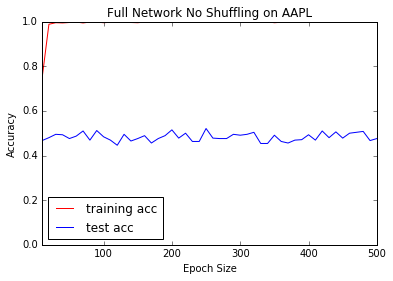

In [14]:
import pylab
pylab.plot(x_axis,training_acc, 'r', label = 'training acc')
pylab.plot(x_axis, test_acc, 'b', label = 'test acc')
pylab.legend(loc = 'lower left')
pylab.xlim(10, 500)
pylab.ylim(0.0,1.0)
pylab.title("Full Network No Shuffling on AAPL")
pylab.xlabel("Epoch Size")
pylab.ylabel("Accuracy")
pylab.show()

In [10]:
def total_embedding_to_class(stock, training_ratio, shuff_bool, epoch_size): 


    #----------------------------LAGS
    day_lag = 1 
    week_lag = 7
    month_lag = 30
    #--------------------------- NN parameters
    input_size = 100
    window_size_convM =3
    hidden_size_convM = 20

    window_size_convL =3 
    hidden_size_convL = 40


    hidden_size_end = 200

    learning_rate = 0.001
    num_epochs = epoch_size
    batch_size = 50

    #training_ratio = 0.8
    #stock = 'AAPL'

    #----------------------------------- PARAMTETRS


    stock_price_csv = pd.read_csv("price_data/"+ stock+"_2006-01-01_to_2017-11-01.csv")

    temp_x = []
    temp_y = []
    for i in range(len(stock_to_events[stock]) ):
        event = stock_to_events[stock][i]


        date_numeric = event[0]
        day = conv_num_to_string( date_numeric    )

        if day in stock_price_csv["Date"].values:

            temp = {}
            temp["day"] = embedding_lst[event[1]]



            row_index = stock_price_csv.index[stock_price_csv["Date"] == day].tolist()[0]
            next_price_data = stock_price_csv.iloc[row_index - day_lag  ]

            next_price = next_price_data["Close"] - next_price_data["Open"]

            if next_price >= 0.0:
                pos_neg_class = 1
            else:
                pos_neg_class = 0
            temp_y.append(pos_neg_class)



            temp["week"] = []
            temp_date_before = 1
            while ( i - temp_date_before >= 0 and numeric_day_distance(stock_to_events[stock][i-temp_date_before][0], date_numeric ) <= week_lag ) :
                temp['week'].append(embedding_lst[stock_to_events[stock][i-temp_date_before][1]]    )
                temp_date_before +=1 

            temp["month"] = []
            temp_date_before = 1
            while ( i - temp_date_before >= 0 and numeric_day_distance(stock_to_events[stock][i-temp_date_before][0], date_numeric ) <= month_lag ) :
                temp['month'].append(embedding_lst[stock_to_events[stock][i-temp_date_before][1]]    )
                temp_date_before +=1 
            temp_x.append(temp)
    #--------------------------------------





    #--------------------------
    sample_size = len(temp_x)
    cut = int(training_ratio*float(sample_size) ) 
    train_x = temp_x[0:cut ]
    test_x = temp_x[cut+1:]

    train_y = temp_y[0:cut]
    test_y = temp_y[cut+1:]


    max_event_length_week = max([len(day_embedding["week"]) for day_embedding in temp_x ])
    max_event_length_month = max([len(day_embedding["month"]) for day_embedding in temp_x ])


    train_x_concatenate = []



    for day_embedding in train_x: 
        block = [day_embedding["day"]]
        week_padding_number = max_event_length_week - len(day_embedding["week"])
        block = block + day_embedding["week"]
        block = block + [[0.0 for i in range(input_size) ] for j in range(week_padding_number)]

        month_padding_number = max_event_length_month - len(day_embedding["month"])
        block = block + day_embedding["month"]
        block = block + [[0.0 for i in range(input_size) ] for j in range(month_padding_number)]


        train_x_concatenate.append(block)

    train_x_concatenate = torch.FloatTensor(train_x_concatenate)

    train_y = torch.LongTensor(train_y)
    train_x_concatenate_temp = torch.utils.data.TensorDataset(train_x_concatenate, train_y)
    train_loader_total = torch.utils.data.DataLoader(dataset=train_x_concatenate_temp, 
                                           batch_size = batch_size, 
                                           shuffle=shuff_bool)



    #-----------------------------------

    test_x_concatenate = []


    for day_embedding in test_x: 
        block = [day_embedding["day"]]
        week_padding_number = max_event_length_week - len(day_embedding["week"])
        block = block + day_embedding["week"]
        block = block + [[0.0 for i in range(input_size) ] for j in range(week_padding_number)]

        month_padding_number = max_event_length_month - len(day_embedding["month"])
        block = block + day_embedding["month"]
        block = block + [[0.0 for i in range(input_size) ] for j in range(month_padding_number)]


        test_x_concatenate.append(block)


    test_x_concatenate = torch.FloatTensor(test_x_concatenate)

    test_y = torch.LongTensor(test_y)
    test_x_concatenate_temp = torch.utils.data.TensorDataset(test_x_concatenate, test_y)
    test_loader_total = torch.utils.data.DataLoader(dataset=test_x_concatenate_temp, 
                                           batch_size = batch_size, 
                                           shuffle=False)



    #------------------------------------------
    class Net(nn.Module):

        def __init__(self, input_size, window_size_convM, hidden_size_convM, window_size_convL, hidden_size_convL, hidden_size_end):
            super(Net, self).__init__()

            self.f1 = nn.Linear(input_size + hidden_size_convM + hidden_size_convL , hidden_size_end)
            self.sigmoid = nn.Sigmoid()
            self.f2 = nn.Linear(hidden_size_end, 2)
            self.softmax = nn.Softmax()

            self.convM = nn.Conv1d(max_event_length_week, hidden_size_convM, window_size_convM, padding = 1 )
            self.poolM = nn.MaxPool1d(input_size)

            self.convL = nn.Conv1d(max_event_length_month, hidden_size_convL, window_size_convL, padding = 1 )
            self.poolL = nn.MaxPool1d(input_size)

        def forward(self, giant_block):

            S = giant_block[:, 0,]

            M = giant_block[:,1: max_event_length_week+1,].contiguous()

            L = giant_block[:,max_event_length_week+1:,].contiguous()

            #--------------------LARGE

            out_L = self.convL(L)
            out_L = self.poolL(out_L)
            out_L = out_L.view(-1, hidden_size_convL)
            #-------------------LARGE

            #------------------- MIDDLE
            out_M = self.convM(M)
            out_M = self.poolM(out_M)
            out_M = out_M.view(-1, hidden_size_convM)
            #-------------------MIDDLE


            #x = concatenation S, M, L
            x = torch.cat((out_L, out_M,S, ), 1) 

            out = self.f1(x)
            out = self.sigmoid(out)
            out = self.f2(out)
            out = self.sigmoid(out) 
            out = self.softmax(out)
            return out 

    net = Net(input_size, window_size_convM, hidden_size_convM, window_size_convL, hidden_size_convL, hidden_size_end )

    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        for i, (inp, outp) in enumerate(train_loader_total):

            inp = Variable(inp, requires_grad=True)
            outp = Variable(outp)

            optimizer.zero_grad()
            outputs = net(inp)
            loss = criterion(outputs, outp.squeeze()  )
            loss.backward()
            optimizer.step()



    correct = 0
    total = 0
    for inp, lab in train_loader_total:
        inp = Variable(inp)

        outputs = net(inp)
        _, predicted = torch.max(outputs.data, 1)
        total += lab.size(0)
        correct += (predicted == lab).sum()


    train_accuracy = float(correct)/total 





    correct = 0
    total = 0
    for inp, lab in test_loader_total:
        inp = Variable(inp, requires_grad=True )

        outputs = net(inp)
        _, predicted = torch.max(outputs.data, 1)
        total += lab.size(0)
        correct += (predicted == lab).sum()


    test_accuracy = float(correct)/total 

    return (str(train_accuracy)[0:5], str(test_accuracy)[0:5] )




In [30]:
total_embedding_to_class('AAPL', 0.7, True)

('1.0', '0.454')

In [ ]:
population = ['GOOGL', 'INTC', 'AAPL', 'CSCO', 'QCOM', 'NVDA', 'AMZN', 'MSFT']
stk_lst = []

training_ratio_population = [0.1*float(i) for i in range(5,10)]
training_ratio_names = [str(0.1*float(i)) + " Training Ratio" for i in range(5,10) ]
for stock in population:
    stock_length = {}
    for j in range(len(training_ratio_population)):
        stock_length[training_ratio_names[j]] = total_embedding_to_class(stock, training_ratio_population[j], False)
    stock_length["Stock Name"] = stock
    stk_lst.append(stock_length)

In [30]:
df = pd.DataFrame(stk_lst)
df[["Stock Name"] + training_ratio_names  ]

,Stock Name,0.5 Training Ratio,0.6 Training Ratio,0.7 Training Ratio,0.8 Training Ratio,0.9 Training Ratio
0,GOOGL,"(0.762, 0.520)","(0.768, 0.516)","(0.786, 0.465)","(0.704, 0.519)","(0.697, 0.447)"
1,INTC,"(0.689, 0.5)","(0.777, 0.523)","(0.733, 0.531)","(0.723, 0.484)","(0.709, 0.5)"
2,AAPL,"(0.869, 0.475)","(0.919, 0.500)","(0.850, 0.459)","(0.919, 0.466)","(0.923, 0.5)"
3,CSCO,"(0.663, 0.604)","(0.654, 0.602)","(0.640, 0.6)","(0.659, 0.5)","(0.618, 0.722)"
4,QCOM,"(0.586, 0.568)","(0.618, 0.559)","(0.582, 0.579)","(0.596, 0.478)","(0.593, 0.391)"
5,NVDA,"(0.642, 0.571)","(0.705, 0.454)","(0.65, 0.5)","(0.652, 0.4)","(0.653, 0.5)"
6,AMZN,"(0.721, 0.574)","(0.626, 0.491)","(0.711, 0.557)","(0.666, 0.406)","(0.778, 0.453)"
7,MSFT,"(0.701, 0.536)","(0.743, 0.518)","(0.749, 0.538)","(0.745, 0.495)","(0.737, 0.483)"


In [ ]:
population = ['GOOGL', 'INTC', 'AAPL', 'CSCO', 'QCOM', 'NVDA', 'AMZN', 'MSFT']
stk_lst = []

training_ratio_population = [0.1*float(i) for i in range(5,10)]
training_ratio_names = [str(0.1*float(i)) + " Training Ratio" for i in range(5,10) ]
for stock in population:
    stock_length = {}
    for j in range(len(training_ratio_population)):
        stock_length[training_ratio_names[j]] = short_term_embedding_to_class(stock, 1, training_ratio_population[j], False)
    stock_length["Stock Name"] = stock
    stk_lst.append(stock_length)

In [32]:
df = pd.DataFrame(stk_lst)
df[["Stock Name"] + training_ratio_names  ]

,Stock Name,0.5 Training Ratio,0.6 Training Ratio,0.7 Training Ratio,0.8 Training Ratio,0.9 Training Ratio
0,GOOGL,"(0.737, 0.551)","(0.545, 0.458)","(0.680, 0.474)","(0.636, 0.467)","(0.631, 0.394)"
1,INTC,"(0.534, 0.468)","(0.544, 0.437)","(0.68, 0.510)","(0.587, 0.437)","(0.633, 0.437)"
2,AAPL,"(0.6, 0.501)","(0.588, 0.499)","(0.594, 0.484)","(0.589, 0.456)","(0.582, 0.461)"
3,CSCO,"(0.663, 0.604)","(0.654, 0.602)","(0.640, 0.6)","(0.659, 0.5)","(0.618, 0.722)"
4,QCOM,"(0.586, 0.568)","(0.561, 0.591)","(0.546, 0.637)","(0.596, 0.478)","(0.593, 0.391)"
5,NVDA,"(0.642, 0.571)","(0.705, 0.454)","(0.65, 0.5)","(0.652, 0.4)","(0.615, 0.5)"
6,AMZN,"(0.655, 0.494)","(0.619, 0.461)","(0.647, 0.5)","(0.555, 0.38)","(0.638, 0.573)"
7,MSFT,"(0.580, 0.476)","(0.674, 0.530)","(0.679, 0.532)","(0.651, 0.570)","(0.655, 0.566)"
